# Image segmentation
## 1.import module

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow_examples.models.pix2pix.pix2pix import upsample
from tensorflow_examples.models.pix2pix.pix2pix import downsample

import tensorflow_advanced_segmentation_models as tasm

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

import os

import Augmentor

from IPython.display import clear_output

from LoadData import Lab2DataLoader

tf.__version__

'2.8.0'

## 2.load data and test data

In [2]:
train_img, test_img, color_codes = Lab2DataLoader().loadData()
INPUT_SHAPE = train_img['image'].shape[1:]
TRAIN_LENGTH = train_img['image'].shape[0]
TEST_LENGTH = test_img['image'].shape[0]
CLASSES = color_codes.shape[0]

cmap = colors.ListedColormap(color_codes / 255.0, "color_codes")
norm = colors.BoundaryNorm(np.arange(0, CLASSES), cmap.N)

print(f'dataset shape: train {train_img["image"].shape} test {test_img["image"].shape}')

dataset shape: train (2975, 128, 256, 3) test (500, 128, 256, 3)


### 2.1 buile tensorflow dataset

In [3]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

### 2.2 Augment random horizontal flip

In [4]:
ratio = 1
trans_factor = (-.05,.05)
zoom_factor = (-.1,0)

class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            # tf.keras.layers.RandomContrast((.5,.5)),
            # tf.keras.layers.RandomTranslation(trans_factor,trans_factor,fill_mode="constant", seed=seed),
            # tf.keras.layers.RandomZoom(zoom_factor,fill_mode="constant", seed=seed),

            # tf.keras.layers.RandomCrop(int(np.round(128 * ratio)), int(np.round(256 * ratio)), seed=seed),
            # tf.keras.layers.Resizing(128, 256, crop_to_aspect_ratio=True)
        ])
        self.augment_labels = tf.keras.models.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            # tf.keras.layers.RandomTranslation(trans_factor,trans_factor,fill_mode="constant", seed=seed),
            # tf.keras.layers.RandomZoom(zoom_factor,fill_mode="constant", seed=seed),

            # tf.keras.layers.RandomCrop(int(np.round(128 * ratio)), int(np.round(256 * ratio)), seed=seed),
            # tf.keras.layers.Resizing(128, 256, crop_to_aspect_ratio=True)
        ])

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
def load_image(dataset):
    input_image = tf.image.resize(dataset['image'], INPUT_SHAPE[:-1])
    input_mask = tf.image.resize(dataset['mask'], INPUT_SHAPE[:-1])
    input_image, input_mask = normalize(input_image), input_mask

    return input_image, input_mask

In [6]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_img)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = (
    train_dataset
        # .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices(test_img)
test_dataset = (
    test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
)

print(train_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None))>


### 2.3 display mask image

In [8]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
            # plt.colorbar()
        plt.axis('off')
    plt.show()

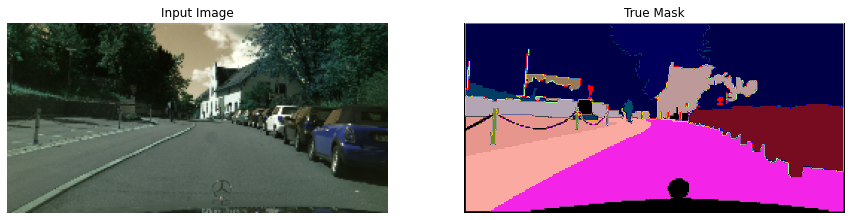

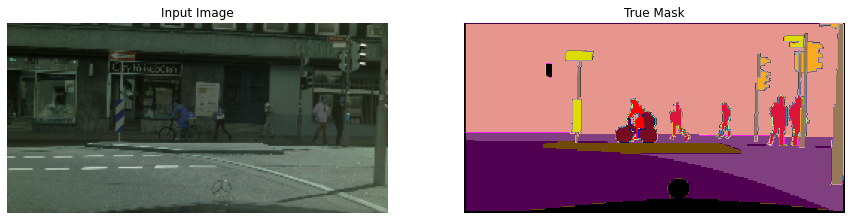

In [9]:
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## 3.Define the model
[U-Net](https://arxiv.org/abs/1505.04597) encoder (downsampler) and decoder (upsampler)

In [10]:
class MIoU(tf.keras.metrics.MeanIoU):
    def __init__(
            self,
            num_classes: int,
            name=None,
            dtype=None,
    ):
        super(MIoU, self).__init__(
            num_classes=num_classes,
            name='MIoU',
            dtype=dtype,
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true = tf.argmax(y_true, axis=-1, output_type=tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

In [11]:
# class AleatoricUncertainty(tf.keras.metrics.Metric):
#     def __init__(self,name=None):
#         name = name or "Aleatoric_Uncertainty"
#         super().__init__(name=name)
#
#     def __call__(self, y_true, y_pred):
#         np.mean(y_pred,0)
#         return =


In [12]:
BACKBONE_NAME = 'densenet121'
WEIGHTS = 'imagenet'
HEIGHT = INPUT_SHAPE[0]
WIDTH = INPUT_SHAPE[1]
base_model, base_model_outputs, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT,
                                                                     width=WIDTH, include_top=False)

Model_Type = 'DeepLabV3plus'
main_net = tasm.DeepLabV3plus(n_classes=CLASSES, base_model=base_model, output_layers=base_model_outputs,
                         backbone_trainable=False,
                         # up_filters = [64, 128, 256, 512, 1024],
                         height=HEIGHT, width=WIDTH
                         ).model()

x = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
model = tf.keras.Model(inputs=[x], outputs=main_net.call(x))

# categorical_focal_dice_loss = tasm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0) + tasm.losses.DiceLoss()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[MIoU(num_classes=CLASSES),
                       'accuracy'])

In [13]:
model._name = f'{Model_Type}_{BACKBONE_NAME}'

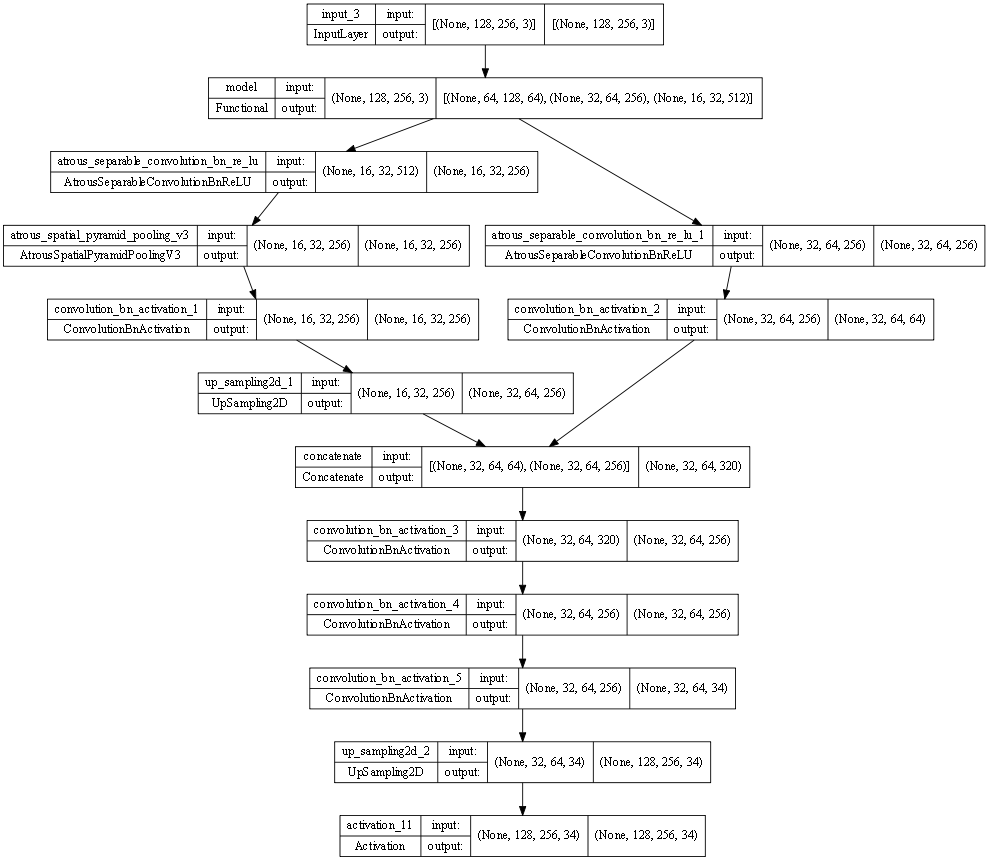

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [15]:
model.summary()

Model: "DeepLabV3plus_densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 128, 64  1313856     ['input_3[0][0]',                
                                ),                                'input_3[0][0]']                
                                 (None, 32, 64, 256                                               
                                ),                                                                
                                 (None, 16, 32, 512                       

## 4.Train the model

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [17]:
def show_predictions(dataset=None, random=True, num=1):
    picker = 0
    if random:
        dataset = dataset.shuffle(BUFFER_SIZE)
    if dataset:
        for image, mask in dataset.take(num):
            if random:
                picker = np.random.randint(0, len(image))
            pred_mask = model.predict(image[picker][tf.newaxis, ...])
            display([image[picker], mask[picker], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

### Test show prediction
display prediction in training

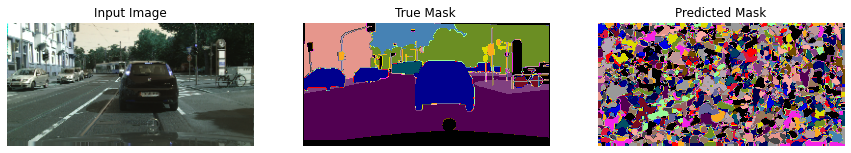

In [18]:
show_predictions(dataset=test_dataset)

### TensorBoard

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

In [20]:
checkpoint_directory = "./training_checkpoints"
checkpoint_name = "ckpt"
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint,
                                     f'checkpoint_directory/{model.name}/',
                                     checkpoint_name=checkpoint_name,
                                     max_to_keep=3)

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(dataset=test_dataset, random=False)
        show_predictions(dataset=test_dataset)
        manager.save()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

In [22]:
# checkpoint.restore(manager.latest_checkpoint)

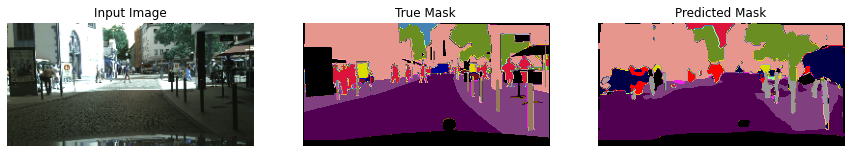

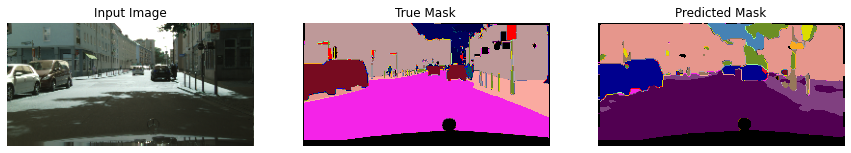


Sample Prediction after epoch 114

186/186 [==============================] - 13s 71ms/step - loss: 0.3396 - MIoU: 0.5738 - accuracy: 0.8989 - val_loss: 0.7623 - val_MIoU: 0.2749 - val_accuracy: 0.8201
Epoch 115/127
 37/186 [====>.........................] - ETA: 8s - loss: 0.3530 - MIoU: 0.5501 - accuracy: 0.8949

KeyboardInterrupt: 

In [23]:
def train(model, manager, EPOCH=20):
    checkpoint.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print(f"Restored from {manager.latest_checkpoint}")
    else:
        print("Initializing Model.")

    initial_epoch = checkpoint.save_counter.numpy()

    LOG_DIR = f'{Model_Type}-dev'

    log_dir = f"./logs/{LOG_DIR}/"
    time_str = datetime.datetime.now().strftime(f"{model.name}_%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir + time_str, histogram_freq=1)

    model_history = model.fit(train_dataset, epochs=EPOCH + initial_epoch,
                              # steps_per_epoch=STEPS_PER_EPOCH,
                              validation_data=test_dataset,
                              initial_epoch=initial_epoch,
                              # validation_steps=VALIDATION_STEPS,
                              callbacks=[DisplayCallback(), tensorboard_callback])


train(model, manager)

In [25]:
def show_uncertainty(image, predict, aleatoric, epistemic):
    plt.figure(figsize=(40, 80))

    title = ['Input Image', 'Predicted Mask', 'Aleatoric Uncertainty', 'Epistemic Uncertainty']
    display_list = [image, predict, aleatoric, epistemic]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 1:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap=cmap)
        else:
            plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
            plt.colorbar(fraction=0.026, pad=0.04)
        plt.axis('off')
    plt.show()

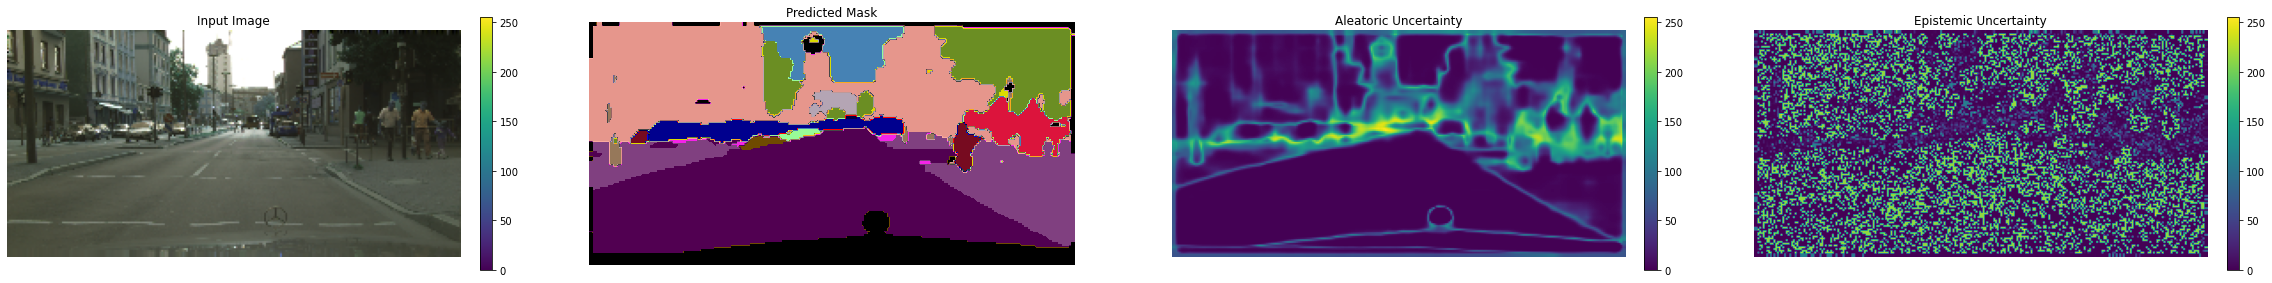

In [27]:
from scipy.stats import entropy
import PIL.Image as Image

test_i = 222
n_sample = 5

test_i_image = test_img['image'][[test_i], :, :, :] / 255.
# test_i_image = tf.image.resize(np.array(Image.open('test.jpg')),(128,256))[tf.newaxis, ...]
preds = [model(test_i_image, training=True)[0] for _ in range(n_sample)]
pred = np.mean(preds, 0)
# aleatoric = tf.argmax(pred, axis=-1)[..., tf.newaxis]
aleatoric = entropy(pred, axis=-1)[..., tf.newaxis]
epistemic = np.std(preds, axis=0).mean(-1)[..., tf.newaxis]
show_uncertainty(test_i_image[0], create_mask(model.predict(test_i_image)), aleatoric, epistemic)

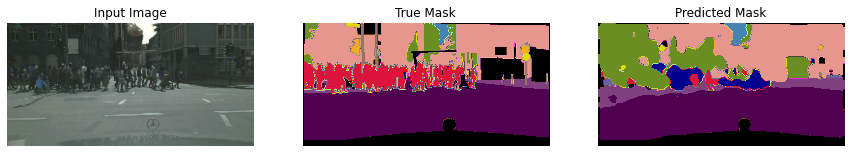

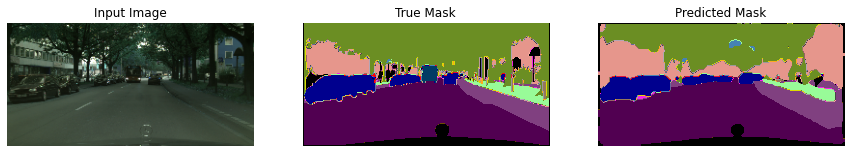

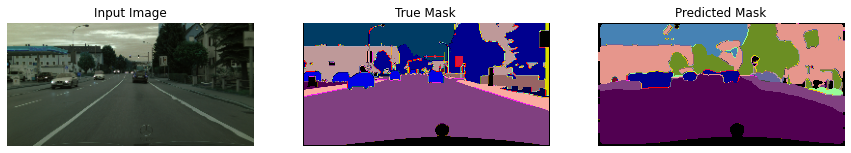

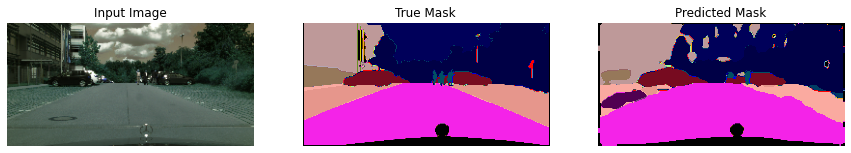

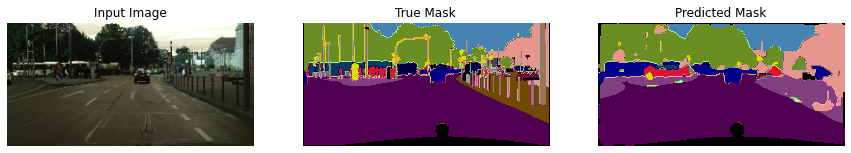

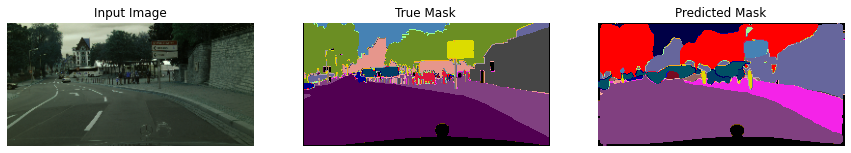

In [23]:
show_predictions(test_dataset, num=2)
show_predictions(train_dataset, num=2)